# SCOG Trip Generation

## Cross-class trip rates

michael.mccarthy@rsginc.com


In [1]:
# setup
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def freqPlot(df, var, query=None):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

    if query != None:
        data = df.query(query)
    else: 
        data = df
    
    counts = data[var].value_counts()
    axes.bar(counts.index, counts.values)
    axes.set_title(var)
    axes.set_xlabel(var)
    axes.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# from Bishoy
def GetTripRatesUsingOneVars(hh_df, trips_df, x, groups, cat, *args, **kwargs):
    """
    Calculate trip rates per cross-classified hhh
    
    Parameters:
    HTS_df: trip records joined to hh + persons
    x: x-class variable no. 1

    groups: trip purpose, i.e., hbs, hbw, ... etc.!
    cat: usually triprate (continous variable), but if trip, we will report the absolute number of trips (discrete)
    """
    HH_PivotTable = hh_df.groupby([x])['hh_weight'].sum().reset_index()
    
    if groups != "all":
        trips_df = trips_df[trips_df["model_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()

    # Finally, pivot the trips using the defined x and y by summing up the trip_weight
    Trip_PivotTable = trips_df.groupby([x])['trip_weight'].sum().reset_index()
    
    if cat == "trip":
        result_table=pd.merge(HH_PivotTable, Trip_PivotTable, left_on=x, right_on=x, how='inner')

    else:
        result_table=pd.merge(HH_PivotTable, Trip_PivotTable, left_on=x, right_on=x, how='inner')
        result_table['trips_rate'] = result_table['trip_weight']/result_table['hh_weight']
    result_table=result_table.fillna(0)
        
    return result_table

def GetTripRatesUsingTwoVars(hh_df, trips_df, x, y, groups, cat, *args, **kwargs):
    """
    Calculate trip rates per cross-classified hhh
    
    Parameters:
    HTS_df: trip records joined to hh + persons
    x: x-class variable no. 1
    y: x-class variable no. 2, if any!
    groups: trip purpose, i.e., hbs, hbw, ... etc.!
    cat: usually triprate (continous variable), but if trip, we will report the absolute number of trips (discrete)
    """
   
    HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
                        columns=[x], aggfunc=np.sum)     # population
    # Filter out the specific trip purpose: ['nhb', 'hbo', 'hbr', 'hbw', 'hbsc', 'hbc']
    if groups != "all":
        trips_df = trips_df[trips_df["model_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()

    # Finally, pivot the trips using the defined x and y by summing up the trip_weight
    dta = "trip_weight"
    Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],
                    columns=[x], aggfunc=np.sum, dropna=False)     # population

    if cat == "trip":
        result_table = Trip_PivotTable
    else:
        result_table = Trip_PivotTable/HH_PivotTable    # get the rates by dividing by the number of hh's in the respective market segment
    result_table=result_table.fillna(0)
    return result_table

# michael
def tripQA(trips_df, lookup_pairs, qa_queries):
    """
        Method for decoding survey codes (trip purpose and mode) and run queries (check reported trip duration/speed) and export sample for QA 

        Parameters:
        trips_df: trips dataframe
        decode: dict of column, lookup pairs, such as {"o_purpose_category": purpose_lookup_dict}

    """

    for dfcol, lookup in lookup_pairs.items():
        trips_df[dfcol+"_decode"] = trips_df[dfcol].map(lookup)

    for dfcol, query in qa_queries.items():
        trips_df[dfcol+"_QA"] = trips_df.eval(query) # return True/False column

    return trips_df

def htsRecordsbyTwoVars(trips_df, count_field, x, y, groups):
     # If counting HH records, pass count_field="hh_id" and groups="all"
     # Filter out the specific trip purpose: ['nhb', 'hbo', 'hbr', 'hbw', 'hbsc', 'hbc']
    if groups != "all":
        trips_df = trips_df[trips_df["model_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()

    Trip_PivotTable = pd.pivot_table(trips_df, values=count_field, index=[y],
                    columns=[x], aggfunc='count', dropna=False)
    
    result_table=Trip_PivotTable.fillna(0)
    return result_table

def htsRecordsbyOneVar(trips_df, count_field, x, groups):
     # If counting HH records, pass count_field="hh_id" and groups="all"
     # Filter out the specific trip purpose: ['nhb', 'hbo', 'hbr', 'hbw', 'hbsc', 'hbc']
    if groups != "all":
        trips_df = trips_df[trips_df["model_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()
    
    Trip_PivotTable = trips_df.groupby([x])[count_field].count().reset_index()
    
    result_table=Trip_PivotTable.fillna(0)
    return result_table

def overallRatePurpose(trips_df, hh_df, groups):
     # If counting HH records, pass count_field="hh_id" and groups="all"
     # Filter out the specific trip purpose: ['nhb', 'hbo', 'hbr', 'hbw', 'hbsc', 'hbc']
    if groups != "all":
        trips_df = trips_df[trips_df["model_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()
    
    hh_table = hh_df[hh_df['hh_id'].isin(trips_df['hh_id'])] # households included in trips subset

    # sum of trips weights / sum of hh weights
    result =  trips_df['trip_weight'].sum() / hh_table['hh_weight'].sum()
    return result



In [3]:
# read in survey tables: households and trips

#trips = pd.read_csv('data/trip.csv')
#hh = pd.read_csv('data/hh.csv')
persons = pd.read_csv('data/person.csv')
days = pd.read_csv('data/day.csv')

# processed trips and HH tables
trips = pd.read_csv('SCOG_HTS_trips.csv')
hh = pd.read_csv('SCOG_HTS_hh.csv')

In [4]:
hh.columns


Index(['Unnamed: 0', 'hh_id', 'income_broad', 'bicycle_type_electric',
       'bicycle_type_other', 'bicycle_type_standard', 'bike_store_garage',
       'bike_store_house', 'bike_store_locker', 'bike_store_other',
       'bike_store_other_object', 'bike_store_rack', 'bike_store_secured_room',
       'bike_store_unlocked', 'complete_fri', 'complete_mon', 'complete_sat',
       'complete_sun', 'complete_thu', 'complete_tue', 'complete_wed',
       'first_travel_date', 'home_bg', 'home_lat', 'home_lon', 'home_park',
       'home_park_pay', 'home_zone', 'home_county', 'income_detailed',
       'last_travel_date', 'micromobility_devices_moped',
       'micromobility_devices_none', 'micromobility_devices_other',
       'micromobility_devices_scooter', 'micromobility_devices_skateboard',
       'num_adults', 'num_bicycles', 'num_days_complete', 'num_people',
       'num_surveyable_people', 'num_vehicles', 'num_workers',
       'participation_group', 'residence_rent_own', 'residence_type',
   

In [5]:
hh[(hh['hh_size'] == 4) &(hh['v_size'] == 0)]

,Unnamed: 0,hh_id,income_broad,bicycle_type_electric,bicycle_type_other,bicycle_type_standard,bike_store_garage,bike_store_house,bike_store_locker,bike_store_other,...,puma_id,income_imputed,income_imputed_label,income_imputed_value,hh_size,w_size,v_size,v_size1p,v_size23p,hh_inc


In [6]:
hh['v_size'].value_counts()

v_size
2    221
1    177
3    123
0     14
Name: count, dtype: int64

## Trip Purposes

In [7]:
trips['model_purpose'].value_counts()

model_purpose
HBO     3058
NHBO    1487
HBW      527
NHBW     510
Loop      12
Name: count, dtype: int64

In [8]:
trips.groupby('model_purpose')['trip_weight'].sum()

model_purpose
HBO     165445.386616
HBW      32808.530906
Loop       693.697663
NHBO     87042.663912
NHBW     39591.343442
Name: trip_weight, dtype: float64

In [9]:
hh['hh_weight'].sum()

np.float64(39897.1242619892)

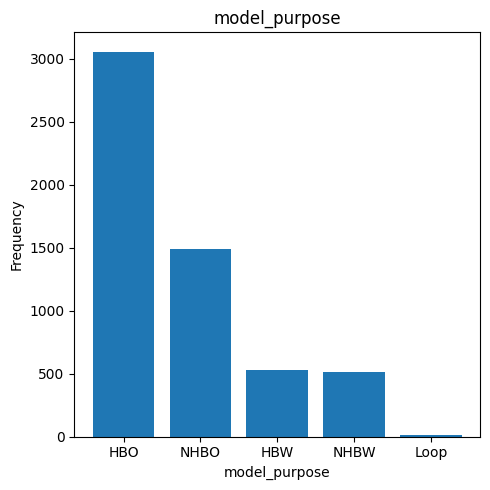

In [6]:
freqPlot(trips,'model_purpose')

In [7]:
# trips by market segment and day of week
markettab = trips.pivot_table(index='market_segment',columns='travel_dow',values='trip_weight', aggfunc='sum')
markettab

# markettab.to_clipboard()

travel_dow,2,3,4
market_segment,,,
II,118149.313949,106209.892332,101222.416258


In [4]:
trips = trips[(trips['market_segment']=='II') & (trips['travel_dow'].isin([2, 3, 4]))]
len(trips)

5594

In [9]:
hh['hh_inc'].value_counts()

hh_inc
INC4    258
INC3    128
INC2     92
INC1     57
Name: count, dtype: int64

In [10]:
# income imputation
nohhinc = hh[hh['hh_inc'] == "NR"]
nohhinc_trips = trips[trips['hh_id'].isin(nohhinc['hh_id'])]

hbo_recs = nohhinc_trips[nohhinc_trips['model_purpose'] == "HBO"]
print('HBO trip records: ',len(hbo_recs))
print('HBO trip weight: ',hbo_recs['trip_weight'].sum())

nhbo_recs = nohhinc_trips[nohhinc_trips['model_purpose'] == "NHBO"]
print('NHBO trip records: ',len(nhbo_recs))
print('NHBO trip records: ',nhbo_recs['trip_weight'].sum())

hbo_all = trips[trips['model_purpose'] == "HBO"]
nhbo_all = trips[trips['model_purpose'] == "NHBO"]

print('HBO total trip records: ',len(hbo_all))
print('HBO total trip weight: ',hbo_all['trip_weight'].sum())

print('NHBO total trip records: ',len(nhbo_all))
print('NHBO total trip weight: ',nhbo_all['trip_weight'].sum())

print('All trip records: ',len(trips))
print('All trip weight: ',trips['trip_weight'].sum())


HBO trip records:  0
HBO trip weight:  0.0
NHBO trip records:  0
NHBO trip records:  0.0
HBO total trip records:  3058
HBO total trip weight:  165445.38661602268
NHBO total trip records:  1487
NHBO total trip weight:  87042.66391202773
All trip records:  5594
All trip weight:  325581.6225395183


## Prepare Trip Rates by HH Category

Join HH categories to trips


In [11]:
# debug
# test = hh.groupby(['w_size']).agg({'hh_weight': ['sum', 'count']}).reset_index()
# complains about multiple levels

In [12]:
hbw1D_trip_rates =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "w_size" , groups = "HBW", cat ="triprate")
hbw1D_trip_rates

,w_size,hh_weight,trip_weight,trips_rate
0,1,13090.527935,8590.358005,0.656227
1,2,12286.788283,17985.581819,1.463815
2,3,2200.861430,6232.591082,2.831887


In [13]:
# HBW without work-related
hbw_trips = trips[(trips['model_purpose'] == 'HBW') & ~(trips['o_purpose_category'] == 3) & ~(trips['d_purpose_category'] == 3)]

hbwnr1D_trip_rates =GetTripRatesUsingOneVars(hh_df = hh, trips_df=hbw_trips,
            x = "w_size" , groups = "HBW", cat ="triprate")
hbwnr1D_trip_rates

,w_size,hh_weight,trip_weight,trips_rate
0,1,13090.527935,6058.430034,0.462810
1,2,12286.788283,13260.526862,1.079251
2,3,2200.861430,5449.089887,2.475890


In [14]:
hbo2D_trip_rates=GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "hh_inc", groups = "HBO", cat ="triprate")
hbo2D_trip_rates

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
hh_inc,,,,
INC1,2.412778,4.092586,2.257888,12.420207
INC2,2.127552,3.228263,6.576492,5.558950
INC3,2.891426,4.277704,3.663875,8.889995
INC4,1.636189,2.854937,2.568439,7.710208


In [15]:
nhbw2D_trip_rates=GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "w_size" , y = "hh_size", groups = "NHBW", cat ="triprate")
nhbw2D_trip_rates

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


w_size,0,1,2,3
hh_size,,,,
1,0.0,0.671057,0.000000,0.000000
2,0.0,0.474390,2.144417,0.000000
3,0.0,0.561490,0.849330,4.342338
4,0.0,0.492232,2.327615,1.008305


In [16]:
nhbo2D_trip_rates=GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "hh_inc", groups = "NHBO", cat ="triprate")
nhbo2D_trip_rates

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
hh_inc,,,,
INC1,2.218349,2.370234,4.909721,4.078607
INC2,2.161314,1.428543,2.013454,1.935617
INC3,1.723704,2.240536,3.660111,6.009284
INC4,0.959450,1.622728,0.740193,2.206176


In [17]:
nhbo2D_trip_rates.to_clipboard()

## Trip rate checks

In [18]:
# all purposes (check)

all1D_trip_rates =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "w_size" , groups = "all", cat ="triprate")
all1D_trip_rates


,w_size,hh_weight,trip_weight,trips_rate
0,0,12318.946614,81201.458485,6.591591
1,1,13090.527935,114152.413139,8.720230
2,2,12286.788283,106917.685202,8.701842
3,3,2200.861430,23310.065714,10.591337


In [19]:
all1D_trip_rates_inc =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "hh_inc" , groups = "all", cat ="triprate")
all1D_trip_rates_inc

,hh_inc,hh_weight,trip_weight,trips_rate
0,INC1,4831.059899,31134.916421,6.444738
1,INC2,7274.887907,49620.083728,6.820735
2,INC3,10272.269952,103873.948354,10.112073
3,INC4,17518.906504,140952.674036,8.045746


In [20]:
all1D_trip_rates_size =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , groups = "all", cat ="triprate")
all1D_trip_rates_size

,hh_size,hh_weight,trip_weight,trips_rate
0,1,9230.158689,45224.491390,4.899644
1,2,17002.982012,117888.752165,6.933416
2,3,4681.874091,41415.731686,8.845973
3,4,8982.109470,121052.647299,13.477084


In [21]:
all1D_trip_rates_veh =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "v_size" , groups = "all", cat ="triprate")
all1D_trip_rates_veh

,v_size,hh_weight,trip_weight,trips_rate
0,0,125.702128,675.753339,5.375831
1,1,10790.357526,67661.410398,6.270544
2,2,16031.877860,135748.231575,8.467394
3,3,12949.186748,121496.227228,9.382537


In [22]:
all1D_trip_rates_veh['trips_rate'].to_clipboard(header=False,index=False)

In [23]:
all1D_trip_rates_size['trips_rate'].to_clipboard(header=False)

In [24]:
all1D_trip_rates_inc['trips_rate'].to_clipboard(header=False)

In [25]:

all2D_trip_rates_inc=GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "hh_inc", groups = "all", cat ="triprate")
all2D_trip_rates_inc

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
hh_inc,,,,
INC1,5.124578,6.920249,9.624085,18.057768
INC2,5.001954,6.790054,9.410779,9.714444
INC3,5.422702,7.961945,10.406244,16.997975
INC4,3.638419,6.407311,7.859284,12.458817


In [26]:


all2D_trip_rates_wrk =GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "w_size", groups = "all", cat ="triprate")
all2D_trip_rates_wrk

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
w_size,,,,
0,5.270193,7.270179,9.184033,9.880221
1,4.449810,6.264283,9.513121,15.361666
2,0.000000,7.012809,7.657855,11.943170
3,0.000000,0.000000,9.744480,13.081325


In [27]:
all2D_trip_rates_veh = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "v_size", groups = "all", cat ="triprate")
all2D_trip_rates_veh

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
v_size,,,,
0,5.411420,10.000000,0.666667,0.000000
1,5.025233,7.241794,10.531005,7.402105
2,5.036042,6.769888,8.126940,12.635200
3,3.256322,7.002052,8.459489,15.832417


In [28]:
all2D_trip_rates_winc = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "w_size" , y = "hh_inc", groups = "all", cat ="triprate")
all2D_trip_rates_winc

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


w_size,0,1,2,3
hh_inc,,,,
INC1,5.783856,7.680188,3.500000,0.000000
INC2,5.996267,6.109506,8.559374,18.975729
INC3,7.159865,13.067688,11.297369,14.822934
INC4,7.081070,8.818718,7.898799,7.876214


In [29]:
HBO2D_trip_rates_inc = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "hh_inc", groups = "HBO", cat ="triprate")
HBO2D_trip_rates_inc

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
hh_inc,,,,
INC1,2.412778,4.092586,2.257888,12.420207
INC2,2.127552,3.228263,6.576492,5.558950
INC3,2.891426,4.277704,3.663875,8.889995
INC4,1.636189,2.854937,2.568439,7.710208


In [30]:
HBO2D_trip_rates_veh = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "v_size", groups = "HBO", cat ="triprate")
HBO2D_trip_rates_veh

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
v_size,,,,
0,1.480838,3.666667,0.333333,0.000000
1,2.386815,4.780718,3.801030,4.488851
2,2.104055,3.248010,4.204322,7.409190
3,1.874758,3.079849,2.609421,9.108349


In [31]:
NHBW2D_trip_rates_veh = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "w_size", groups = "NHBW", cat ="triprate")
NHBW2D_trip_rates_veh

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
w_size,,,,
0,0.000000,0.000000,0.000000,0.000000
1,0.671057,0.474390,0.561490,0.492232
2,0.000000,2.144417,0.849330,2.327615
3,0.000000,0.000000,4.342338,1.008305


In [32]:
NHBO2D_trip_rates_inc = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "hh_inc", groups = "NHBO", cat ="triprate")
NHBO2D_trip_rates_inc

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
hh_inc,,,,
INC1,2.218349,2.370234,4.909721,4.078607
INC2,2.161314,1.428543,2.013454,1.935617
INC3,1.723704,2.240536,3.660111,6.009284
INC4,0.959450,1.622728,0.740193,2.206176


In [33]:
NHBO2D_trip_rates_veh = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "v_size", groups = "NHBO", cat ="triprate")
NHBO2D_trip_rates_veh

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
v_size,,,,
0,3.455485,0.333333,0.333333,0.000000
1,1.951792,1.904746,2.389197,2.436674
2,1.979092,1.700699,1.690282,3.074860
3,1.096698,1.959882,1.656725,3.762261


In [34]:
HBO1D_trip_rates_hh =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , groups = "HBO", cat ="triprate")
HBO1D_trip_rates_hh

,hh_size,hh_weight,trip_weight,trips_rate
0,1,9230.158689,21027.263969,2.278104
1,2,17002.982012,57883.208894,3.404297
2,3,4681.874091,16059.131488,3.430065
3,4,8982.109470,70475.782266,7.846240


In [35]:
HBO1D_trip_rates_inc =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "hh_inc" , groups = "HBO", cat ="triprate")
HBO1D_trip_rates_inc

,hh_inc,hh_weight,trip_weight,trips_rate
0,INC1,4831.059899,16658.409544,3.448189
1,INC2,7274.887907,25477.722626,3.502146
2,INC3,10272.269952,52546.409108,5.115365
3,INC4,17518.906504,70762.845338,4.039227


In [36]:
HBO1D_trip_rates_veh =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "v_size" , groups = "HBO", cat ="triprate")
HBO1D_trip_rates_veh

,v_size,hh_weight,trip_weight,trips_rate
0,0,125.702128,192.564310,1.531910
1,1,10790.357526,34732.055935,3.218805
2,2,16031.877860,71536.076577,4.462115
3,3,12949.186748,58984.689794,4.555088


In [37]:
NHBW1D_trip_rates_wrk =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "w_size" , groups = "NHBW", cat ="triprate")
NHBW1D_trip_rates_wrk

,w_size,hh_weight,trip_weight,trips_rate
0,1,13090.527935,7173.917013,0.548024
1,2,12286.788283,24722.786684,2.012144
2,3,2200.861430,7694.639745,3.496195


In [38]:
NHBW1D_trip_rates_hh =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , groups = "NHBW", cat ="triprate")
NHBW1D_trip_rates_hh

,hh_size,hh_weight,trip_weight,trips_rate
0,1,9230.158689,2797.681856,0.303102
1,2,17002.982012,15847.323274,0.932032
2,3,4681.874091,9134.114493,1.950953
3,4,8982.109470,11812.223820,1.315083


In [39]:
NHBO1D_trip_rates_hh =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , groups = "NHBO", cat ="triprate")
NHBO1D_trip_rates_hh

,hh_size,hh_weight,trip_weight,trips_rate
0,1,9230.158689,17644.079947,1.911568
1,2,17002.982012,31185.282981,1.834107
2,3,4681.874091,8643.000851,1.846056
3,4,8982.109470,29570.300132,3.292133


In [40]:
NHBO1D_trip_rates_inc =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "hh_inc" , groups = "NHBO", cat ="triprate")
NHBO1D_trip_rates_inc

,hh_inc,hh_weight,trip_weight,trips_rate
0,INC1,4831.059899,11678.295197,2.417336
1,INC2,7274.887907,13742.548449,1.889039
2,INC3,10272.269952,33653.263676,3.276127
3,INC4,17518.906504,27968.556590,1.596478


In [41]:
NHBO1D_trip_rates_veh =GetTripRatesUsingOneVars(hh_df = hh, trips_df=trips,
            x = "v_size" , groups = "NHBO", cat ="triprate")
NHBO1D_trip_rates_veh

,v_size,hh_weight,trip_weight,trips_rate
0,0,125.702128,388.603323,3.091462
1,1,10790.357526,21772.348899,2.017760
2,2,16031.877860,34458.120100,2.149350
3,3,12949.186748,30423.591590,2.349460


In [42]:
NHBO1D_trip_rates_veh['trips_rate'].to_clipboard(header=False,index=False)

In [43]:
# unweighted total trips/HH

hhPersons_df = pd.merge(hh, persons, left_on='hh_id', right_on='hh_id', how='outer')

HTS_df = pd.merge(trips, hhPersons_df, left_on=['person_id','person_num', 'hh_id'], 
                  right_on=['person_id','person_num', 'hh_id'])

day_weight = days.filter(['hh_id', 'day_num', 'day_weight'])
day_weight

HTS_dayWeighted_df = pd.merge(HTS_df, day_weight, left_on=['hh_id','day_num'], 
                  right_on=['hh_id','day_num'])

hh_weekdays = hh[hh['hh_id'].isin(HTS_dayWeighted_df['hh_id'].unique())]
hh_weekdays

,Unnamed: 0,hh_id,income_broad,bicycle_type_electric,bicycle_type_other,bicycle_type_standard,bike_store_garage,bike_store_house,bike_store_locker,bike_store_other,...,puma_id,income_imputed,income_imputed_label,income_imputed_value,hh_size,w_size,v_size,v_size1p,v_size23p,hh_inc
0,0,21000012,3,995,995,995,995,995,995,995,...,25701,3,"$50,000-$74,999",74999.0,3,2,2,1,2,INC3
1,3,21000109,2,995,995,995,995,995,995,995,...,25701,2,"$25,000-$49,999",49999.0,1,0,1,1,1,INC2
2,5,21000352,1,995,995,995,995,995,995,995,...,25701,1,"Under $25,000",24999.0,1,1,1,1,1,INC1
3,7,21000567,1,995,995,995,995,995,995,995,...,25701,1,"Under $25,000",24999.0,1,0,1,1,1,INC1
4,8,21000694,4,0,0,1,0,1,0,0,...,25701,4,"$75,000-$99,999",99999.0,1,1,2,1,2,INC4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,666,21029685,999,0,0,1,0,1,0,0,...,25701,3,"$50,000-$74,999",74999.0,2,0,3,1,2,INC3
531,667,21029712,4,1,0,1,0,1,0,0,...,25701,4,"$75,000-$99,999",99999.0,2,0,2,1,2,INC4
532,668,21029804,5,0,0,1,0,1,0,0,...,25701,5,"$100,000-$199,999",199999.0,4,2,3,1,2,INC4
533,670,21029948,2,995,995,995,995,995,995,995,...,25701,2,"$25,000-$49,999",49999.0,2,0,2,1,2,INC2


In [44]:
Overall_rates_weighted = HTS_dayWeighted_df['trip_weight'].sum()/hh_weekdays['hh_weight'].sum()
Overall_rates_weighted

np.float64(24.083222875599343)

In [45]:
Overall_rates_Unweighted = len(HTS_dayWeighted_df['trip_id'].unique())/len(hh_weekdays['hh_id'].unique())
Overall_rates_Unweighted

10.45607476635514

In [46]:
persons.columns

Index(['age', 'bike_freq', 'bike_helmet', 'commute_freq',
       'commute_freq_pre_covid', 'commute_subsidy_bike_maintenance',
       'commute_subsidy_bikeshare', 'commute_subsidy_carshare',
       'commute_subsidy_dk', 'commute_subsidy_incentives',
       ...
       'work_in_region', 'work_lat', 'work_lon', 'work_mode',
       'work_mode_pre_covid', 'work_zone', 'workplace_post_covid', 'hh_id',
       'num_days_complete', 'person_weight'],
      dtype='object', length=161)

In [47]:
# get households where all persons report being retired or unemployed, not looking for work
# check by comparing to age codes: 
# 8	    55-64
# 9     65-74
# 10	75-84
# 11	85 or older

nonretired_p = persons[persons['employment'] != 5]
retired_p = persons[persons['employment'] == 5]
nonret_hh_id = nonretired_p['hh_id'].unique()
ret_hh_id = retired_p['hh_id'].unique()

retired_hh_id = ret_hh_id[~np.isin(ret_hh_id,nonret_hh_id)]


In [48]:
ret_persons = persons[persons['hh_id'].isin(retired_hh_id)]
ret_persons['age'].value_counts()

age
9     217
10    107
8      55
11     20
7       7
5       4
6       2
3       2
Name: count, dtype: int64

In [49]:
ret_persons[ret_persons['age'] < 7]

,age,bike_freq,bike_helmet,commute_freq,commute_freq_pre_covid,commute_subsidy_bike_maintenance,commute_subsidy_bikeshare,commute_subsidy_carshare,commute_subsidy_dk,commute_subsidy_incentives,...,work_in_region,work_lat,work_lon,work_mode,work_mode_pre_covid,work_zone,workplace_post_covid,hh_id,num_days_complete,person_weight
276,5,7,2,995,995,995,995,995,995,995,...,995,NaN,NaN,-9998,995,NaN,995,21005746,1,9.601833
314,6,7,995,995,995,995,995,995,995,995,...,995,NaN,NaN,-9998,995,NaN,995,21006921,1,142.647249
483,5,2,996,995,995,995,995,995,995,995,...,995,NaN,NaN,-9998,995,NaN,995,21011319,7,8.041616
629,5,7,995,995,995,995,995,995,995,995,...,995,NaN,NaN,-9998,995,NaN,995,21013723,7,8.147593
988,6,7,995,995,995,995,995,995,995,995,...,995,NaN,NaN,-9998,995,NaN,995,21021472,1,13.026268
1160,5,7,995,995,2,995,995,995,995,995,...,995,NaN,NaN,-9998,100,NaN,995,21025095,6,52.248241
1167,3,995,995,995,995,995,995,995,995,995,...,995,NaN,NaN,-9998,995,NaN,995,21025564,1,16.345976
1168,3,995,995,995,995,995,995,995,995,995,...,995,NaN,NaN,-9998,995,NaN,995,21025564,1,16.345976


In [50]:
# HH 21025564 is a retired senior + 2 non-worker teens
# HH 21005746 is a retired senior + person 25-34, both disabled
# HH 21006921 is one person age 35-44, looking for work pre-covid and not looking post
# HH 21011319 is one person age 25-34 with a disability
# HH 21013723 is one person age 25-34 with a disability
# HH 21025095 is one person age 25-34 employed pre-covid, now unemployed


persons[persons['hh_id'] == 21025095]

,age,bike_freq,bike_helmet,commute_freq,commute_freq_pre_covid,commute_subsidy_bike_maintenance,commute_subsidy_bikeshare,commute_subsidy_carshare,commute_subsidy_dk,commute_subsidy_incentives,...,work_in_region,work_lat,work_lon,work_mode,work_mode_pre_covid,work_zone,workplace_post_covid,hh_id,num_days_complete,person_weight
1160,5,7,995,995,2,995,995,995,995,995,...,995,NaN,NaN,-9998,100,NaN,995,21025095,6,52.248241


In [51]:
retired_hh = hh[hh['hh_id'].isin(retired_hh_id)]
nonretired_hh = hh[~hh['hh_id'].isin(retired_hh_id)]
retired_hh

,Unnamed: 0,hh_id,income_broad,bicycle_type_electric,bicycle_type_other,bicycle_type_standard,bike_store_garage,bike_store_house,bike_store_locker,bike_store_other,...,puma_id,income_imputed,income_imputed_label,income_imputed_value,hh_size,w_size,v_size,v_size1p,v_size23p,hh_inc
3,7,21000567,1,995,995,995,995,995,995,995,...,25701,1,"Under $25,000",24999.0,1,0,1,1,1,INC1
7,11,21000800,3,0,0,1,0,1,0,0,...,25701,3,"$50,000-$74,999",74999.0,2,0,3,1,2,INC3
12,17,21001065,1,0,0,1,0,1,0,0,...,25701,1,"Under $25,000",24999.0,1,0,2,1,2,INC1
13,18,21001236,2,995,995,995,995,995,995,995,...,25701,2,"$25,000-$49,999",49999.0,2,0,2,1,2,INC2
14,19,21001260,1,995,995,995,995,995,995,995,...,25701,1,"Under $25,000",24999.0,1,0,1,1,1,INC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,660,21029489,3,0,0,1,0,1,0,0,...,25701,3,"$50,000-$74,999",74999.0,1,0,1,1,1,INC3
530,666,21029685,999,0,0,1,0,1,0,0,...,25701,3,"$50,000-$74,999",74999.0,2,0,3,1,2,INC3
531,667,21029712,4,1,0,1,0,1,0,0,...,25701,4,"$75,000-$99,999",99999.0,2,0,2,1,2,INC4
533,670,21029948,2,995,995,995,995,995,995,995,...,25701,2,"$25,000-$49,999",49999.0,2,0,2,1,2,INC2


In [52]:
retired_trips = trips[trips['hh_id'].isin(retired_hh_id)]
nonretired_trips = trips[~trips['hh_id'].isin(retired_hh_id)]

In [53]:
all1D_trip_rates_retired =GetTripRatesUsingOneVars(hh_df = retired_hh, trips_df=retired_trips,
            x = "hh_inc" , groups = "all", cat ="triprate")
all1D_trip_rates_retired

,hh_inc,hh_weight,trip_weight,trips_rate
0,INC1,2096.877846,12496.417317,5.959535
1,INC2,2400.826312,13845.302090,5.766890
2,INC3,4213.719267,30417.217585,7.218615
3,INC4,2349.023970,15474.190776,6.587498


In [54]:
all1D_trip_rates_retired['trip_weight'].sum() / all1D_trip_rates_retired['hh_weight'].sum()

np.float64(6.530760030647205)

In [55]:
all1D_trip_rates_nonretired =GetTripRatesUsingOneVars(hh_df = nonretired_hh, trips_df=nonretired_trips,
            x = "hh_inc" , groups = "all", cat ="triprate")
all1D_trip_rates_nonretired

,hh_inc,hh_weight,trip_weight,trips_rate
0,INC1,2734.182053,18638.499104,6.816846
1,INC2,4874.061595,35774.781638,7.339830
2,INC3,6058.550685,73456.730768,12.124472
3,INC4,15169.882533,125478.483260,8.271553


In [56]:
all1D_trip_rates_nonretired['trip_weight'].sum() / all1D_trip_rates_nonretired['hh_weight'].sum()

np.float64(8.785634209508622)

In [57]:
hhrecs_retired = htsRecordsbyOneVar(trips_df=retired_hh, count_field='hh_id', x = "hh_inc", groups = "all")
hhrecs_retired

,hh_inc,hh_id
0,INC1,33
1,INC2,41
2,INC3,55
3,INC4,67


In [58]:
hhrecs_nonretired = htsRecordsbyOneVar(trips_df=nonretired_hh, count_field='hh_id', x = "hh_inc", groups = "all")
hhrecs_nonretired

,hh_inc,hh_id
0,INC1,24
1,INC2,51
2,INC3,73
3,INC4,191


In [59]:
hhrecs_nonretired['hh_id'].to_clipboard()

## Trip and HH record counts

In [60]:
triprecsHBW = htsRecordsbyOneVar(trips_df=trips, count_field='trip_id', x = "w_size", groups = "HBW")
triprecsHBW

,w_size,trip_id
0,1,276
1,2,224
2,3,27


In [61]:
hhrecsHBW = htsRecordsbyOneVar(trips_df=hh, count_field='hh_id', x = "w_size", groups = "all")
hhrecsHBW

,w_size,hh_id
0,0,225
1,1,197
2,2,104
3,3,9


In [62]:
# HH making HBW trips
HBW_trips = trips[trips['model_purpose'] == "HBW"]
HBW_hh_id = HBW_trips['hh_id'].unique()
HBW_hh = hh[hh['hh_id'].isin(HBW_hh_id)]
HBW_hh.groupby('w_size')['hh_id'].count().reset_index()

,w_size,hh_id
0,1,100
1,2,73
2,3,7


In [63]:
triprecsHBO = htsRecordsbyTwoVars(trips_df=trips, count_field='trip_id', x = "hh_size" , y = "hh_inc", groups = "HBO")
triprecsHBO

hh_size,1,2,3,4
hh_inc,,,,
INC1,122,51,6,20
INC2,125,190,116,68
INC3,222,265,93,143
INC4,111,792,166,568


In [64]:
# HH making HBO trips
HBO_trips = trips[trips['model_purpose'] == "HBO"]
HBO_hh_id = HBO_trips['hh_id'].unique()
HBO_hh = hh[hh['hh_id'].isin(HBO_hh_id)]

In [65]:
hhrecsHBO = htsRecordsbyTwoVars(trips_df=HBO_hh, count_field='hh_id', x = "hh_size" , y = "hh_inc", groups = "all")
hhrecsHBO

hh_size,1,2,3,4
hh_inc,,,,
INC1,39,9,3,2
INC2,37,36,9,7
INC3,42,50,13,11
INC4,33,140,23,32


In [66]:
hhrecsHBO = htsRecordsbyTwoVars(trips_df=HBO_hh, count_field='hh_id', x = "hh_size" , y = "v_size", groups = "all")
hhrecsHBO

hh_size,1,2,3,4
v_size,,,,
0,10.0,1.0,1.0,0.0
1,108.0,47.0,11.0,4.0
2,26.0,120.0,18.0,32.0
3,7.0,67.0,18.0,16.0


In [67]:
hhrecsHBO = htsRecordsbyTwoVars(trips_df=hh, count_field='hh_id', x = "hh_size" , y = "v_size", groups = "all")
hhrecsHBO

hh_size,1,2,3,4
v_size,,,,
0,12.0,1.0,1.0,0.0
1,114.0,48.0,11.0,4.0
2,31.0,135.0,22.0,33.0
3,9.0,76.0,20.0,18.0


In [68]:
hhrecsHBO.to_clipboard()

In [69]:
# HH making NHBW trips
NHBW_trips = trips[trips['model_purpose'] == "NHBW"]
NHBW_hh_id = NHBW_trips['hh_id'].unique()
NHBW_hh = hh[hh['hh_id'].isin(NHBW_hh_id)]

In [70]:
triprecsNHBW = htsRecordsbyTwoVars(trips_df=trips, count_field='trip_id', x = "w_size" , y = "hh_size", groups = "NHBW")
triprecsNHBW

w_size,1,2,3
hh_size,,,
1,121.0,0.0,0.0
2,93.0,129.0,0.0
3,11.0,11.0,21.0
4,27.0,69.0,28.0


In [71]:
hhrecsNHBW = htsRecordsbyTwoVars(trips_df=NHBW_hh, count_field='hh_id', x = "hh_size" , y = "w_size", groups = "all")
hhrecsNHBW

hh_size,1,2,3,4
w_size,,,,
1,34.0,23.0,6.0,8.0
2,0.0,33.0,5.0,11.0
3,0.0,0.0,3.0,1.0


In [72]:
hhrecsNHBW.to_clipboard()

In [73]:
# HH making NHBO trips
NHBO_trips = trips[trips['model_purpose'] == "NHBO"]
NHBO_hh_id = NHBO_trips['hh_id'].unique()
NHBO_hh = hh[hh['hh_id'].isin(NHBO_hh_id)]

In [74]:
triprecsNHBO = htsRecordsbyTwoVars(trips_df=trips, count_field='trip_id', x = "hh_size" , y = "hh_inc", groups = "NHBO")
triprecsNHBO

hh_size,1,2,3,4
hh_inc,,,,
INC1,88,23,10,4
INC2,97,101,27,44
INC3,105,95,35,130
INC4,60,393,62,213


In [75]:
hhrecsNHBO = htsRecordsbyTwoVars(trips_df=NHBO_hh, count_field='hh_id', x = "hh_size" , y = "hh_inc", groups = "all")
hhrecsNHBO

hh_size,1,2,3,4
hh_inc,,,,
INC1,28,6,3,2
INC2,28,26,6,5
INC3,30,32,11,9
INC4,20,90,12,21


In [76]:
hhrecsNHBO = htsRecordsbyTwoVars(trips_df=NHBO_hh, count_field='hh_id', x = "hh_size" , y = "v_size", groups = "all")
hhrecsNHBO

hh_size,1,2,3,4
v_size,,,,
0,8.0,1.0,1.0,0.0
1,78.0,30.0,9.0,4.0
2,13.0,82.0,11.0,23.0
3,7.0,41.0,11.0,10.0


In [77]:
hhrecsNHBO.to_clipboard()

In [78]:
hhrecs_veh = htsRecordsbyOneVar(trips_df=hh, count_field='hh_id', x = "v_size", groups = "all")
hhrecs_veh

,v_size,hh_id
0,0,14
1,1,177
2,2,221
3,3,123


In [79]:
hhrecs_veh['hh_id'].to_clipboard(header=False,index=False)

In [80]:
hhrecs2dveh = htsRecordsbyTwoVars(trips_df=hh, count_field='hh_id', x = "hh_size" , y = "v_size", groups = "all")
hhrecs2dveh

hh_size,1,2,3,4
v_size,,,,
0,12.0,1.0,1.0,0.0
1,114.0,48.0,11.0,4.0
2,31.0,135.0,22.0,33.0
3,9.0,76.0,20.0,18.0


In [81]:
hhrecs2dincwrk = htsRecordsbyTwoVars(trips_df=hh, count_field='hh_id', x = "w_size" , y = "hh_inc", groups = "all")
hhrecs2dincwrk

w_size,0,1,2,3
hh_inc,,,,
INC1,41.0,15.0,1.0,0.0
INC2,49.0,34.0,8.0,1.0
INC3,59.0,47.0,20.0,2.0
INC4,76.0,101.0,75.0,6.0


In [82]:
hhrecs2dincwrk.to_clipboard(header=False,index=False)

## Collapse HBO rates by auto ownership

In [83]:
# 1 person
HBO2D_trip_rates_veh_1p = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "v_size1p", groups = "HBO", cat ="triprate")
HBO2D_trip_rates_veh_1p

# 2-3 person
HBO2D_trip_rates_veh_23p = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=trips,
            x = "hh_size" , y = "v_size23p", groups = "HBO", cat ="triprate")
HBO2D_trip_rates_veh_23p

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future ver

hh_size,1,2,3,4
v_size23p,,,,
0,1.480838,3.666667,0.333333,0.000000
1,2.386815,4.780718,3.801030,4.488851
2,2.043823,3.168822,3.315400,8.116436


In [84]:
HBO2D_trip_rates_veh_23p.to_clipboard(header=False,index=False)

## Collapse NHB Rates

In [5]:
nhb_trips = trips.copy()

# recode NHB cat
nhb_trips.loc[nhb_trips['model_purpose'].isin(['NHBO','NHBW']),'model_purpose'] = 'NHB'

In [86]:
nhb_trips['model_purpose'].value_counts()

model_purpose
HBO     3058
NHB     1997
HBW      527
Loop      12
Name: count, dtype: int64

In [87]:

# size x inc
NHB2D_trip_rates_inc = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=nhb_trips,
            x = "hh_size" , y = "hh_inc", groups = "NHB", cat ="triprate")
NHB2D_trip_rates_inc

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
hh_inc,,,,
INC1,2.510210,2.477974,6.141686,5.117910
INC2,2.376705,2.839082,2.410827,2.009059
INC3,2.102100,3.293800,5.193625,7.676776
INC4,1.387066,2.506677,3.323087,3.710272


In [88]:
NHB2D_trip_rates_inc.to_clipboard(header=False,index=False)

In [89]:
NHB1D_trip_rates_inc =GetTripRatesUsingOneVars(hh_df = hh, trips_df=nhb_trips,
            x = "hh_inc" , groups = "NHB", cat ="triprate")
NHB1D_trip_rates_inc

,hh_inc,hh_weight,trip_weight,trips_rate
0,INC1,4831.059899,13108.390003,2.713357
1,INC2,7274.887907,17792.104521,2.445688
2,INC3,10272.269952,45580.918650,4.437278
3,INC4,17518.906504,50152.594181,2.862770


In [90]:
NHB1D_trip_rates_size =GetTripRatesUsingOneVars(hh_df = hh, trips_df=nhb_trips,
            x = "hh_size" , groups = "NHB", cat ="triprate")
NHB1D_trip_rates_size

,hh_size,hh_weight,trip_weight,trips_rate
0,1,9230.158689,20441.761803,2.214671
1,2,17002.982012,47032.606255,2.766139
2,3,4681.874091,17777.115344,3.797008
3,4,8982.109470,41382.523952,4.607217


In [91]:
NHB1D_trip_rates_size.to_clipboard(header=False,index=False)

In [92]:

# size x vehicles
NHB2D_trip_rates_veh = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=nhb_trips,
            x = "hh_size" , y = "v_size", groups = "NHB", cat ="triprate")
NHB2D_trip_rates_veh

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],


hh_size,1,2,3,4
v_size,,,,
0,3.697666,1.666667,0.333333,0.000000
1,2.322200,2.189347,4.154840,2.589464
2,2.165785,2.647305,2.573129,4.367568
3,1.104875,3.110212,4.572429,5.333454


In [93]:
NHB2D_trip_rates_veh.to_clipboard(header=False,index=False)

In [94]:
NHB1D_trip_rates_veh =GetTripRatesUsingOneVars(hh_df = hh, trips_df=nhb_trips,
            x = "v_size" , groups = "NHB", cat ="triprate")
NHB1D_trip_rates_veh

,v_size,hh_weight,trip_weight,trips_rate
0,0,125.702128,424.791635,3.379351
1,1,10790.357526,27018.856501,2.503982
2,2,16031.877860,49739.409567,3.102532
3,3,12949.186748,49450.949651,3.818846


In [95]:
NHB1D_trip_rates_veh.to_clipboard(header=False,index=False)

In [96]:
# 1 person
NHB2D_trip_rates_veh_1p = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=nhb_trips,
            x = "hh_size" , y = "v_size1p", groups = "NHB", cat ="triprate")
NHB2D_trip_rates_veh_1p

# 2-3 person
NHB2D_trip_rates_veh_23p = GetTripRatesUsingTwoVars(hh_df = hh, trips_df=nhb_trips,
            x = "hh_size" , y = "v_size23p", groups = "NHB", cat ="triprate")
NHB2D_trip_rates_veh_23p

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:72: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],
C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_27712\2127856191.py:62: FutureWarning: The provided callable <function sum at 0x000002D3D638FA60> is currently using DataFrameGroupBy.sum. In a future ver

hh_size,1,2,3,4
v_size23p,,,,
0,3.697666,1.666667,0.333333,0.000000
1,2.322200,2.189347,4.154840,2.589464
2,1.887103,2.865290,3.687444,4.769602


In [97]:
NHB2D_trip_rates_veh_23p.to_clipboard(header=False,index=False)

## Overall Rates by Purpose

In [98]:
hbw_rate = overallRatePurpose(trips, hh, 'HBW')
hbw_rate

np.float64(1.9999811285897238)

In [99]:
hbo_rate = overallRatePurpose(trips, hh, 'HBO')
hbo_rate

np.float64(4.555896332048948)

In [100]:
nhbw_rate = overallRatePurpose(trips, hh, 'NHBW')
nhbw_rate

np.float64(3.3806927666869533)

In [101]:
nhbo_rate = overallRatePurpose(trips, hh, 'NHBO')
nhbo_rate

np.float64(3.665262450922964)

In [102]:
nhb_rate = overallRatePurpose(nhb_trips, hh, 'NHB')
nhb_rate

np.float64(4.366672948695418)

## Person trips to Vehicle trips

In [10]:
# Mode share
trips.loc[(trips['mode_type'].isin([5,6,7,8,9])),'auto_trip_weight'] = trips['trip_weight']
trips.loc[trips['model_purpose'].isin(['NHBO','NHBW']),'model_purpose'] = 'NHB'
purpose_auto_share = trips.groupby('model_purpose')[['trip_weight','auto_trip_weight']].sum().reset_index()
purpose_auto_share['factor'] = purpose_auto_share['auto_trip_weight'] / purpose_auto_share['trip_weight']
purpose_auto_share.to_csv('auto_mode_share_by_purpose.csv',index=False)

In [15]:
# Auto occupancy
trips.loc[(trips['mode_type'] == 8),'auto_trip_weight'] = trips['trip_weight']
trips.loc[((trips['mode_type'] == 8) & (trips['driver'] == 1)),'driver_trip_weight'] = trips['trip_weight']
purpose_auto_occ = trips.groupby('model_purpose')[['auto_trip_weight','driver_trip_weight']].sum().reset_index()
purpose_auto_occ['factor'] = purpose_auto_occ['auto_trip_weight'] / purpose_auto_occ['driver_trip_weight']
purpose_auto_occ.to_csv('auto_occupancy_by_purpose.csv',index=False)

In [ ]:
trips.loc[((trips['mode_type'] == 8) & (trips['driver'] == 1)) | (trips['mode_type'].isin([5,6,9])),'veh_trip_weight'] = trips['trip_weight']
trips['veh_trip_weight'] = trips['veh_trip_weight'].fillna(0)

auto_purpose = trips.groupby('model_purpose')[['trip_weight','veh_trip_weight']].sum().reset_index()
auto_purpose['factor'] = auto_purpose['veh_trip_weight'] / auto_purpose['trip_weight']
auto_purpose

,model_purpose,trip_weight,veh_trip_weight,factor
0,HBO,165445.386616,96664.310775,0.584267
1,HBW,32808.530906,30711.741857,0.936090
2,Loop,693.697663,124.549338,0.179544
3,NHBO,87042.663912,57461.917596,0.660158
4,NHBW,39591.343442,34752.533727,0.877781


In [108]:
nhb_trips.loc[((nhb_trips['mode_type'] == 8) & (nhb_trips['driver'] == 1)) | (nhb_trips['mode_type'].isin([5,6,9,11])),'veh_trip_weight'] = nhb_trips['trip_weight']
nhb_trips['veh_trip_weight'] = nhb_trips['veh_trip_weight'].fillna(0)

auto_purpose = nhb_trips.groupby('model_purpose')[['trip_weight','veh_trip_weight']].sum().reset_index()
auto_purpose['factor'] = auto_purpose['veh_trip_weight'] / auto_purpose['trip_weight']
auto_purpose.to_csv('AutoVehicleTripFactors_NHB.csv')
